In [1]:
from utils import *
from config_file import DATASETS_PATH, DOWNLOAD_ROOT, DOWNLOAD_URL, TWEETS_PATH

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "sentiment_analysis_ML"

if not os.path.isdir("images"):
    os.makedirs("images")
        
if not os.path.isdir("models"):
    os.makedirs("models")
    
MODEL_PATH = os.path.join('models', PROJECT_ID)
        
IMAGE_PATH = os.path.join("images", PROJECT_ID)

if not os.path.isdir(MODEL_PATH):
        os.makedirs(MODEL_PATH)

if not os.path.isdir(IMAGE_PATH):
        os.makedirs(IMAGE_PATH)
        
MODELS_STORE_PATH = os.path.join(PROJECT_ROOT_DIR, MODEL_PATH)
IMAGES_STORE_PATH = os.path.join(PROJECT_ROOT_DIR, IMAGE_PATH)

def save_model(model_name, model):
    path = os.path.join(MODELS_STORE_PATH, model_name)
    model.save(path)
    
def load_model(model_path, model):
    return model.load(model_path)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_STORE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import string
import unicodedata
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, Word2Vec, IDF
from pyspark.ml.feature import  IndexToString
from pyspark.ml.feature import StringIndexer, StopWordsRemover, VectorAssembler, VectorIndexer
from pyspark.ml.classification import LinearSVC, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVCModel, NaiveBayesModel, LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vector
import re
from pyspark.conf import SparkConf
from pyspark.sql import functions as F
import string
import csv
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.types import ArrayType

In [4]:
spark = SparkSession.builder\
    .master("local[3]")\
    .appName("nlp")\
    .config("spark.executor.memory", "128g")\
    .config("spark.driver.memory", "128g")\
    .config("spark.memory.offHeap.enabled",True) \
    .config("spark.memory.offHeap.size","64g")\
    .config("spark.debug.maxToStringFields","256")\
    .getOrCreate()

## Training the model 

In [7]:
extract_tar_file(tgz_name= "training_data.tar.gz")

In [8]:
csv_path = os.path.join(DATASETS_PATH, 'training_data/training_text_classification.csv')
training_df = spark.read.format("libsvm")\
        .csv(csv_path, inferSchema=True, encoding = 'ISO-8859-1', header=False)\
        .selectExpr('_c0 as label', '_c5 as text')

In [9]:
training_df.count()

1600000

In [10]:
udfhttps=udf(lambda text: remove_https(text), StringType())
udfNormalizeData=udf(lambda text: normalizeData(text), StringType())
udfDecoding=udf(lambda text: clean_latin(text), StringType())

In [11]:
training_df= training_df.withColumn("text", udfhttps(training_df["text"]))
training_df = training_df.withColumn("text", udfNormalizeData(training_df["text"]))
training_df= training_df.withColumn("text", udfDecoding(training_df["text"]))
training_df = lower_words(training_df)

In [12]:
training_df.show(2)

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    0| switchfoot   aww...|
|    0|is upset that he ...|
+-----+--------------------+
only showing top 2 rows



In [13]:
training_df = training_df.withColumn('length',length(training_df['text']))

In [14]:
training_df = training_df.withColumn("label", \
              when(training_df["label"] == 4, 1).otherwise(training_df["label"]))

In [15]:
training_df.where((col("label") == 0.0)).count()

800000

In [16]:
training_df.where((col("label") == 1.0)).count()

800000

In [17]:
training_df.show(2)

+-----+--------------------+------+
|label|                text|length|
+-----+--------------------+------+
|    0| switchfoot   aww...|    89|
|    0|is upset that he ...|   110|
+-----+--------------------+------+
only showing top 2 rows



In [18]:
acc_eval = MulticlassClassificationEvaluator()

# Preparing data for Logistic Regression and SVM

In [19]:
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='features')
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
#featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
#labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel")

data_prep_pipe = Pipeline(stages=[tokenizer,stopremove, count_vec])
cleaner_lr = data_prep_pipe.fit(training_df)
data_lr = cleaner_lr.transform(training_df)

data_lr = data_lr.select(['label','features'])

# Logistic Regression

In [20]:
# Split the data into training and test sets (10% held out for testing)
(trainingData, testData) = data_lr.randomSplit([0.9, 0.1])

# We can also use the multinomial family for binary classification
mlr = LogisticRegression(family="multinomial")

# Train model.  This also runs the indexers.
model_lr = mlr.fit(trainingData)

In [36]:
# save_model("logistic_regression", model_lr)

In [37]:
# path = os.path.join(MODELS_STORE_PATH, "logistic_regression")
# saved_model_lr = load_model(path, LogisticRegressionModel)

./models/sentiment_analysis_ML/logistic_regression


In [38]:
# Make predictions.
# predictions_lr = saved_model_lr.transform(testData)
# acc = acc_eval.evaluate(predictions_lr)
# print("Accuracy of model at predicting sentiment wiht logistic regression is: {}".format(acc))

Accuracy of model at predicting sentiment wiht logistic regression is: 0.6467255384703975


In [19]:
# Make predictions.
predictions_lr = model_lr.transform(testData)
acc = acc_eval.evaluate(predictions_lr)
print("Accuracy of model at predicting sentiment wiht logistic regression is: {}".format(acc))

Accuracy of model at predicting sentiment wiht logistic regression is: 0.750852408946616


# Linear SVM

In [18]:
# Split the data into training and test sets (10% held out for testing)
(trainingData, testData) = data_lr.randomSplit([0.9, 0.1])
# Train model.
svm = LinearSVC(maxIter= 10)
model_svm = svm.fit(trainingData)

In [ ]:
# save_model("svm", model_svm)

In [24]:
# Make predictions.
predictions_svm = model_svm.transform(testData)
acc = acc_eval.evaluate(predictions_svm)
print("Accuracy of model at predicting sentiment with SVM is: {}".format(acc))

Accuracy of model at predicting sentiment with SVM is: 0.7707139719967024


# Naive Bayes

## Preparing data for Naive Bayes

In [17]:
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
clean_up = VectorAssembler(inputCols=['tf_idf','length'],outputCol='features')

data_prep_pipe = Pipeline(stages=[tokenizer,stopremove, count_vec, idf, clean_up])
cleaner_nb = data_prep_pipe.fit(training_df)
data_np = cleaner_nb.transform(training_df)
data_np = data_np.select(['label', 'features'])

In [18]:
# Split the data into training and test sets (10% held out for testing)
(trainingData,testData) = data_np.randomSplit([0.9,0.1], seed=42)

# Train the Model
nb = NaiveBayes()
model_nb = nb.fit(trainingData)

In [ ]:
save_model("naive_bayes", model_nb)

In [19]:
# Make Prediction
predictions_nb =model_nb.transform(testData)

acc = acc_eval.evaluate(predictions_nb)
print("Accuracy of model at predicting sentiment with Naive Bayes is: {}".format(acc))

Accuracy of model at predicting sentiment with Naive Bayes is: 0.7422832448858636


# Multilayer Perceptron Classifier

## Preparing data for MLP

In [17]:
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
word2vec = Word2Vec(inputCol='stop_tokens', outputCol = 'words_vector') 
clean_up = VectorAssembler(inputCols=['words_vector','length'],outputCol='features')

data_prep_pipe = Pipeline(stages=[tokenizer,stopremove,word2vec, clean_up])
cleaner_mlp = data_prep_pipe.fit(training_df)
data_mlp = cleaner_mlp.transform(training_df)
data_mlp = data_mlp.select(['label','features'])

In [18]:
(training, testing) = data_mlp.randomSplit([0.9,0.1])

layers = [101, 25, 2]
mlp = MultilayerPerceptronClassifier(layers= layers)
model_mlp = mlp.fit(training)

In [19]:
predictions_mlp = model_mlp.transform(testing)
acc = acc_eval.evaluate(predictions_mlp)
print("Accuracy of model at predicting sentiment using MLP is: {}".format(acc))

Accuracy of model at predicting sentiment was using MLP: 0.6715418982239492


# Preprocessed Tweets

In [ ]:
extract_tar_file(tgz_name="preproccessed_tweets_date.tar.gz")

In [5]:
h_avg = spark.read.json('./datasets/sentiment_analysis/tweets_avg_happiness.json')
h_words = spark.read.json('./datasets/sentiment_analysis/tweets_classification.json')

In [6]:
h_avg.show(2)

+--------------------+-------------+
|                date|happiness_avg|
+--------------------+-------------+
|2018-06-15T11:23:...|        6.595|
|2018-06-15T11:23:...|        6.454|
+--------------------+-------------+
only showing top 2 rows



In [7]:
h_words.show(2)

+--------------------+--------------------+
|                date|     happiness_words|
+--------------------+--------------------+
|2018-06-15T11:23:...|[good, work, get,...|
|2018-06-15T11:23:...|[next, peeps, enj...|
+--------------------+--------------------+
only showing top 2 rows



**Some extre cleaning**

In [8]:
h_words = h_words.withColumn('date' , regexp_replace('date', "[\.tT]", ' '))
h_avg = h_avg.withColumn('date' , regexp_replace('date', "[\.tT]", ' '))

split_col = pyspark.sql.functions.split(h_words['date'], ' ')
h_words = h_words.withColumn('time', split_col.getItem(1))
h_words = h_words.withColumn('date', split_col.getItem(0))
h_words = h_words.withColumn('date' , (concat(col("date"), lit(" "), col("time")))).drop('time')

split_col = pyspark.sql.functions.split(h_avg['date'], ' ')
h_avg = h_avg.withColumn('time', split_col.getItem(1))
h_avg = h_avg.withColumn('date', split_col.getItem(0))
h_avg = h_avg.withColumn('date' , (concat(col("date"), lit(" "), col("time")))).drop('time')

h_words = h_words.createOrReplaceTempView('h_words')
h_words = spark.sql('select row_number() over (order by "date") as num, * from h_words')

h_avg.createOrReplaceTempView('h_avg')
h_avg = spark.sql('select row_number() over (order by "date") as num, * from h_avg')

In [9]:
h_words.show(2)

+---+-------------------+--------------------+
|num|               date|     happiness_words|
+---+-------------------+--------------------+
|  1|2018-06-15 11:23:49|[good, work, get,...|
|  2|2018-06-15 11:23:49|[next, peeps, enj...|
+---+-------------------+--------------------+
only showing top 2 rows



In [10]:
# joining two dataframe (h_words, h_avg)

h_avg_words = h_words.join(h_avg, on='num', how = 'inner')\
                                    .drop('num').select(col('h_words.date').alias('date'),\
                                    col('happiness_words').alias('happiness_words'),\
                                    col('happiness_avg').alias('happiness_avg'))

In [11]:
h_avg_words.show(2)

+-------------------+--------------------+-------------+
|               date|     happiness_words|happiness_avg|
+-------------------+--------------------+-------------+
|2018-06-15 11:23:49|[good, work, get,...|        6.595|
|2018-06-15 11:23:49|[next, peeps, enj...|        6.454|
+-------------------+--------------------+-------------+
only showing top 2 rows



In [12]:
# removing the instances with less than four words
h_avg_words = h_avg_words.where(size(col("happiness_words")) >= 4)
h_avg_words = h_avg_words.withColumn("text", concat_ws(" ", "happiness_words"))
h_avg_words.show(2)

+-------------------+--------------------+-------------+--------------------+
|               date|     happiness_words|happiness_avg|                text|
+-------------------+--------------------+-------------+--------------------+
|2018-06-15 11:23:49|[good, work, get,...|        6.595|good work get wor...|
|2018-06-15 11:23:49|[next, peeps, enj...|        6.454|next peeps enjoy ...|
+-------------------+--------------------+-------------+--------------------+
only showing top 2 rows



In [ ]:
data_happiness = cleaner_lr.transform(h_avg_words)
data_happainess = data_happiness.select('date','happiness_avg','features')
happiness_prediction =model_lr.transform(data_happainess)
happiness_prediction.show(2)

In [33]:
happiness_prediction.where((col("happiness_avg") > 6.0) & (col("prediction") == 1)).count()

165084

In [34]:
happiness_prediction.where((col("happiness_avg") > 6.0) & (col("prediction") == 0)).count()

34617

In [35]:
happiness_prediction.where((col("happiness_avg") < 4.0) & (col("prediction") == 0)).count()

1145

In [36]:
happiness_prediction.where((col("happiness_avg") < 4.0) & (col("prediction") == 1)).count()

1963

In [37]:
happiness_prediction.where((col("happiness_avg")>= 4.0) & (col("happiness_avg")<= 6.0)).count()

127640

In [38]:
happiness_prediction.count()

330449

In [39]:
330449-127640

202809

In [14]:
df = h_avg_words.where((col("happiness_avg")< 4.0) | (col("happiness_avg")> 6.0))

In [15]:
df.count()

202809

In [25]:
df = h_avg_words.withColumn("label", F.when(h_avg_words["happiness_avg"]<4, 0).\
                            when(h_avg_words["happiness_avg"]>6, 1).otherwise('Neutral'))

In [26]:
df = df.toPandas()

Saving figure tweets_label_distribution


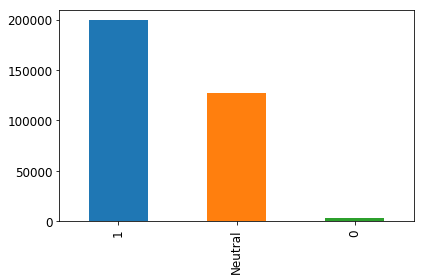

In [27]:
df['label'].value_counts().plot(kind='bar' , )
save_fig("tweets_label_distribution")

In [43]:
haw_pandas.head(2)

,date,happiness_words,happiness_avg,text
0,2018-06-15 11:23:49,"[good, work, get, worldcup]",6.595,good work get worldcup
1,2018-06-15 11:23:49,"[next, peeps, enjoy, games, please, spare, tim...",6.454,next peeps enjoy games please spare time preci...
